# Adaptive noise cancellation demo

 This notebook demonstrates adaptive noise cancellation (ANC) techniques for removing power line interference from signals.
 
 The demo shows how to:
 - Generate synthetic data with power line noise
 - Apply adaptive RLS filtering to cancel the noise
 - Evaluate the filtering performance
 
 The code implements the algorithm described in ["Adaptive cancellation of mains power interference in continuous gravitational wave searches with a hidden Markov model"](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.110.122004)

 ---
 


## 0. Setup 

In [2]:
# %%
%load_ext autoreload
%autoreload 2

In [3]:
import sys 
sys.path.append('../python/')


## 1. Synthetic data 




In [ ]:
import numpy as np 
from ANC.generate_synthetic_data import simulate_data
from ANC.hmm_viterbi import viterbi_for_ANC
from adaptive_filters import arls_n


# Generate simulated data
# The signal measured in the strain channel is x(t) = h(t) + c(t) + n(t)
# where h(t) is the GW signal, c(t) is the non-Gaussian interference, and n(t) is Gaussian noise.
# Separately, the reference signal is r(t) = A_ac * cos(2πf0t + θ(t)) + n_r(t)
# where A_ac is the amplitude of the reference signal, f0 is the central frequency, and θ(t) is the phase noise.
# See the paper for more details.

print("Generating simulated data")

## Sampling parameters 
W = 1000  # Sampling frequency
N = 2**14 # Number of samples per block
T = N/W   # Time within one block
Nb = 50  # Number of frequency blocks for simulated GW signal


## GW parameters 
sigma_f = 1e-2  # Standard deviation of GW frequency
fq      = np.cumsum(np.concatenate(([59.5], sigma_f * np.sqrt(T) * np.random.randn(Nb-1)))) #array of random GW frequencies, see Equation 20 and 21 in paper. Note that the frequency updates are happing at the block level rather than every sample point.
h0      = 0.03   # GW signal amplitude


## Clutter parameters 


## Gaussian noise parameters 
sigma_n     = 1.0    # Standard deviation of Gaussian noise (strain channel)


## Reference signal parameters 


sigma_r     = 2.0    # Standard deviation of reference signal measurement noise
A_ac        = 1.0    # Amplitude of reference signal
A_r         = 10.0   # Amplitude factor for reference
gamma_a     = 0.1    # Phase fluctuation parameter (related to 1/P in paper)
D_fac       = 1.0    # Amplitude of phase modulation (Δfac in paper)



f0          = 60.0 # Hz, central frequency 









sigma_theta = 0.01   # Standard deviation of phase noise (σΘ in paper)

x, r, injection, time, original_reference = simulate_data(
    f0=f0,
    fq=fq, 
    h0=h0,
    sigma_n=sigma_n,
    W=W,
    N=N,
    sigma_r=sigma_r,
    A_ac=A_ac,
    A_r=A_r,
    gamma_a=gamma_a,
    D_fac=D_fac,
    sigma_theta=sigma_theta
)






# # Apply RLS filter
# print("Applying RLS filter")
# lambda_val = 1
# c_RLS, _, _,_= arls_n(s, r, 36, lambda_val) # cancelled, adap, fit, P 


# # Evaluate using Viterbi
# print("Evaluating using Viterbi")
# score, _,_ = viterbi_for_ANC(gamma, s, N, Nb, T, W) #score, fhat, y0 
# score_RLS, _,_= viterbi_for_ANC(gamma, c_RLS, N, Nb, T, W)
    
 

Generating simulated data


NameError: name 'gamma' is not defined

(55.0, 65.0)

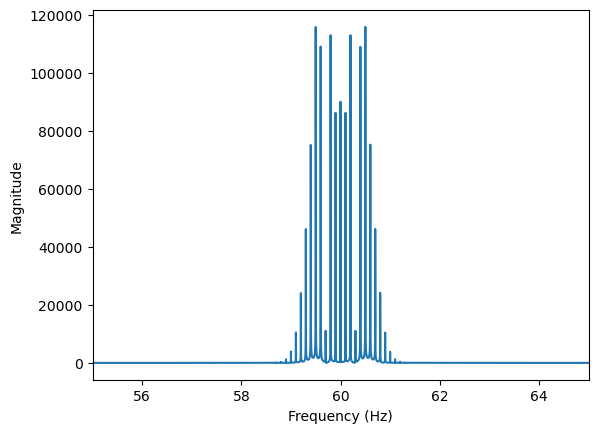

In [35]:
dt = time[1]-time[0]
fs = 1/dt
s = original_reference 
fft_result = np.fft.fft(s)
N = len(s)
freq = np.fft.fftfreq(N, d=dt)



# Get the magnitude spectrum (absolute value)
magnitude_spectrum = np.abs(fft_result)

# If you want the power spectrum
power_spectrum = np.abs(fft_result)**2

# Note: The FFT is symmetric for real signals, so often you only want the positive frequencies
# You can get these by:
positive_freq = freq[:N//2]
positive_magnitude = magnitude_spectrum[:N//2]



plt.plot(positive_freq, positive_magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(55,65)

In [17]:
score 

np.float64(12.835255946276277)

50

In [ ]:
    from python.
    
    W = 1000  # Sampling frequency
    N = 2**14
    T = N/W
    Nb = 50
    gamma = 1e-2  # Standard deviation of GW frequency
    
    # Generate random frequencies
    fq = np.cumsum(np.concatenate(([59.5], gamma * np.sqrt(T) * np.random.randn(Nb-1))))
    
    # Generate simulated data
    s, r, _, _, _ = simulate_data(f0, fq, h, H, W, N, Q, ampr0, ampr, gamma_a)
    
    # Apply RLS filter
    lambda_val = 1
    c_RLS, _, _,_= arls_n(s, r, 36, lambda_val) # cancelled, adap, fit, P 
    
    
    # Evaluate using Viterbi
    score, _,_ = viterbi_for_ANC(gamma, s, N, Nb, T, W) #score, fhat, y0 
    score_RLS, _,_= viterbi_for_ANC(gamma, c_RLS, N, Nb, T, W)
    
    return score, score_RLS